# Machine Learning

In [1]:
#Importamos las librerias
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import category_encoders as ce
import spacy
import en_core_web_sm
import nltk
from pandas import DataFrame
from spacy import displacy
from wordcloud import WordCloud
from pandas import DataFrame
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Perceptron
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier

plt.style.use('default')
nlp = en_core_web_sm.load()

## Funciones

In [2]:
#Funcion para definir la locacion
def MeQuedoConLocacion(Primero,Segundo,Tercero,Cuarto):
    if(pd.isna(Primero)) & (pd.isna(Segundo)) & (pd.isna(Tercero)):
        return 'Sin Locacion'
    if(pd.isna(Primero)) & (pd.isna(Segundo)) & (pd.notna(Tercero)):
        return Cuarto
    if(pd.isna(Primero)):
        return Segundo
    if(pd.isna(Segundo)):
        return Primero

In [3]:
def oneHotEncoding(df, columna):
    one_hot = pd.get_dummies(df[columna])
    df.drop(columna, axis=1, inplace=True)
    df = pd.concat([df, one_hot], axis=1)
    return df

In [4]:
def stem_tokens(tokens, stemmer):
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed

### Carga de los CSVs

In [5]:
#Cargamos el set de entrenamiento
train=pd.read_csv('Data/train.csv')
train['text']=train['text'].str.lower()
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,our deeds are the reason of this #earthquake m...,1
1,4,NaN,NaN,forest fire near la ronge sask. canada,1
2,5,NaN,NaN,all residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,just got sent this photo from ruby #alaska as ...,1


In [6]:
#Cargamos el csv de las Ciudades
ciudades=pd.read_csv('Data/worldcities.csv')
ciudades=ciudades[['city','country']]
ciudades.head()

,city,country
0,Tokyo,Japan
1,New York,United States
2,Mexico City,Mexico
3,Mumbai,India
4,São Paulo,Brazil


In [7]:
#Cargamos el csv con los Paises del mundo
mundo=pd.read_csv('Data/Mundo.csv')
mundo=mundo[['name','iso_a3']]
mundo.head()

,name,iso_a3
0,Fiji,FJI
1,Tanzania,TZA
2,W. Sahara,ESH
3,Canada,CAN
4,United States,USA


In [8]:
#Cargamos el csv con los hashtags mas utilizados
hashtags=pd.read_csv('Data/Hashtags_Total.csv')
hashtags.set_index('Hashtag',inplace=True)
hashtags.head()

,Unnamed: 0
Hashtag,
News,1
Hot,0
Best,1609
Prebreak,1167
Nowplaying,3


In [9]:
#Cargamos el csv con las menciones mas utilizados
arrobas=pd.read_csv('Data/Arroba_Total.csv')
arrobas['Mencion']=arrobas['Mencion'].str.lower()
arrobas.set_index('Mencion',inplace=True)
arrobas.head()

,Unnamed: 0
Mencion,
youtube,0
arianagrande,5
potus,6
foxnews,7
change,1


## 1) Set de Entrenamiento

### 1.1) Generamos los Features

#### 1.1.1) Analisis de Locacion

In [10]:
#Separo la locacion por las comas
separacion_coma=pd.concat([train, train['location'].str.split(',', expand=True)], axis=1)
separacion_coma.rename(columns={0:'Primero',1:'Segundo',2:'Tercero'},inplace=True)
separacion_coma.drop(columns={'location',3},inplace=True)
separacion_coma.head()

,id,keyword,text,target,Primero,Segundo,Tercero
0,1,NaN,our deeds are the reason of this #earthquake m...,1,NaN,NaN,NaN
1,4,NaN,forest fire near la ronge sask. canada,1,NaN,NaN,NaN
2,5,NaN,all residents asked to 'shelter in place' are ...,1,NaN,NaN,NaN
3,6,NaN,"13,000 people receive #wildfires evacuation or...",1,NaN,NaN,NaN
4,7,NaN,just got sent this photo from ruby #alaska as ...,1,NaN,NaN,NaN


In [11]:
#Me quedo con la primer parte de la separación ya que vimos que es la más importante
#Mapeo para cada ciudad, su pais
primera_ciudad=separacion_coma[['id','Primero']].copy()
primera_ciudad.rename(columns={'Primero':'city'},inplace=True)
ciudad_pais=pd.merge(primera_ciudad,ciudades,on='city',how='left')
ciudad_pais.drop_duplicates(subset="id",keep="first",inplace=True)

In [12]:
#Mapeo para cada abreviacion, su pais
primera_abreviacion=separacion_coma[['id','Primero']].copy()
primera_abreviacion.rename(columns={'Primero':'iso_a3'},inplace=True)
abreviacion_pais=pd.merge(primera_abreviacion,mundo,on='iso_a3',how='left')
abreviacion_pais.drop_duplicates(subset="id",keep="first",inplace=True)

In [13]:
#Verifico si en la primer coma esta bien la locacion
primera_pais=separacion_coma[['id','Primero']].copy()
primera_pais.rename(columns={'Primero':'name'},inplace=True)
pais=pd.merge(primera_pais,mundo,on='name',how='left')
pais.drop_duplicates(subset="id",keep="first",inplace=True)
pais.rename(columns={'iso_a3':'abreviacion'},inplace=True)
pais.drop(columns={'name'},inplace=True)

In [14]:
junto=pd.merge(abreviacion_pais,ciudad_pais,on='id',how='inner')
junto=pd.merge(junto,pais,on='id',how='inner')
junto['Locacion']=junto.apply(lambda x: MeQuedoConLocacion(x['name'],x['country'],x['abreviacion'],x['iso_a3']),axis=1)
junto_final=junto[['id','Locacion']]

#Lo Joineo con el set de entrenamiento
train=pd.merge(train,junto_final,on='id',how='inner')
train.head()

,id,keyword,location,text,target,Locacion
0,1,NaN,NaN,our deeds are the reason of this #earthquake m...,1,Sin Locacion
1,4,NaN,NaN,forest fire near la ronge sask. canada,1,Sin Locacion
2,5,NaN,NaN,all residents asked to 'shelter in place' are ...,1,Sin Locacion
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,Sin Locacion
4,7,NaN,NaN,just got sent this photo from ruby #alaska as ...,1,Sin Locacion


#### 1.1.2) Analisis Sintáctico

In [15]:
#Parse del texto , donde cada token es una palabra

for i, row in train.iterrows():
  
    if(row["text"] and len(str(row["text"])) < 300):
        doc = nlp(str(row["text"]))
        
        adjectives = []
        nouns = []
        verbs = []
        lemmas = []
        simbolos = []
        alfanumericos = []

        for token in doc:
            
            lemmas.append(token.lemma_)
            
            if not token.text.isalpha():
                alfanumericos.append(token.lemma_)
            if token.pos_ == "ADJ":
                adjectives.append(token.lemma_)
            if token.pos_ == "NOUN" or token.pos_ == "PROPN":
                nouns.append(token.lemma_)
            if token.pos_ == "VERB":
                verbs.append(token.lemma_)
            if token.pos_ == "SYM":
                simbolos.append(token.lemma_)
         
        train.at[i, "adjetivos"] = " ".join(adjectives)
        train.at[i, "verbos"] = " ".join(verbs)
        train.at[i, "longitud"] = len(row["text"])
        
print('Completado')

Completado


In [16]:
train['rango']=pd.cut(train['longitud'],[0,10,20,30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,180,190,200])

In [17]:
#Me quedo con la cantidad que considere necesario
top_20_keywords = train['keyword'].value_counts().head(10).index
top_20_verbos = train['verbos'].astype('str').value_counts().head(20).index
top_20_adjetivos = train['adjetivos'].astype('str').value_counts().head(20).index
top_50_locaciones = train['Locacion'].astype('str').value_counts().head(50).index
top_10_hashtags = hashtags.head(10).index
top_10_arrobas = arrobas.head(10).index

In [18]:
#Agrego un booleano con respecto a si tienen los simbolos enunciados
train['Tiene_arroba']=train['text'].str.contains('@')
train['Tiene_hashtag']=train['text'].str.contains('#')
train['Tiene_signo_pregunta']=train['text'].str.contains('\?|¿')
train['Tiene_signo_exclamacion']=train['text'].str.contains('!|¡')
train['Tiene_link']=train['text'].str.contains('https')

In [19]:
english_stopwords = stopwords.words('english')
stemmer = SnowballStemmer('english')

aQuitar = ['http','https','&amp']
english_stopwords.extend(aQuitar)

In [20]:
texto = train["text"]

textoVeridico = train[(train['target']==1)]
textoVeridico = textoVeridico["text"]

textoFalso = train[(train['target']==0)]
textoFalso = textoFalso["text"]

In [21]:
palabrasVeridicas=[]
for row in textoVeridico:
    row =row.lower()
    row=filter(None, re.split("[, \-!?:._¡¿'`<>;()+]", row))
    for palabra in row:
        if len(palabra)<4: #saco conectores
            continue
        if palabra not in english_stopwords:
            palabrasVeridicas.append(palabra)

In [22]:
palabrasFalsas=[]
for row in textoFalso:
    row =row.lower()
    row=filter(None, re.split("[, \-!?:._¡¿'`<>;()+]", row))
    for palabra in row:
        if len(palabra)<4: #saco conectores
            continue
        if palabra not in english_stopwords:
            palabrasFalsas.append(palabra)

In [23]:
stems = stem_tokens(palabrasVeridicas, stemmer)
contador = Counter(stems)
palabrasComunesVeridicas = contador.most_common(100)
dfPalabrasComunesV = DataFrame(palabrasComunesVeridicas,columns=['Palabra','Cantidad'])

In [24]:
stems = stem_tokens(palabrasFalsas, stemmer)
contador = Counter(stems)
palabrasComunesFalsas = contador.most_common(100)
dfPalabrasComunesF = DataFrame(palabrasComunesFalsas,columns=['Palabra','Cantidad'])

In [25]:
popularesEnComun = dfPalabrasComunesV.merge(dfPalabrasComunesF,left_on='Palabra',right_on='Palabra',how='inner')

In [26]:
popularesExclusivamenteV = dfPalabrasComunesV[(~dfPalabrasComunesV.Palabra.isin(popularesEnComun.Palabra))]
popularesExclusivamenteF = dfPalabrasComunesF[(~dfPalabrasComunesF.Palabra.isin(popularesEnComun.Palabra))]

In [27]:
TopPopularesExclusivamenteV = popularesExclusivamenteV.nlargest(20, 'Cantidad')
TopPopularesExclusivamenteV.sort_values('Cantidad',inplace=True)

In [28]:
TopPopularesExclusivamenteF = popularesExclusivamenteF.nlargest(20, 'Cantidad')
TopPopularesExclusivamenteF.sort_values('Cantidad',inplace=True)

#### 1.1.3) Aplicación de los procesamientos

In [29]:
train = oneHotEncoding(train,'rango')

In [30]:
for columna in popularesExclusivamenteV['Palabra']:
    train[columna+'_text']=train.text.str.contains(columna,case=False)

In [31]:
for columna in popularesExclusivamenteF['Palabra']:
    train[columna+'_text']=train.text.str.contains(columna,case=False)

In [32]:
for key_top in top_20_keywords:
    train[key_top]=train['keyword'].str.contains(key_top)

In [33]:
for verbo_top in top_20_verbos:
    train[verbo_top]=train['verbos'].str.contains(verbo_top)

In [34]:
for adjetivos_top in top_20_adjetivos:
    train[adjetivos_top]=train['adjetivos'].str.contains(adjetivos_top)

In [35]:
for locacion_top in top_50_locaciones:
    train[locacion_top]=train['Locacion'].str.contains(locacion_top)

In [36]:
for hastag_top in top_10_hashtags:
    train[hastag_top]=train['text'].str.contains('#'+hastag_top)

In [37]:
for arroba_top in top_10_arrobas:
    train[arroba_top]=train['text'].str.contains('@'+arroba_top)

In [38]:
#Quito las columnas que no necesito y relleno los NaNs con False
train.drop(columns={'location','Locacion','keyword','text','adjetivos','verbos','longitud'},inplace=True)
train.fillna(False,inplace=True)
train.head()

,id,target,Tiene_arroba,Tiene_hashtag,Tiene_signo_pregunta,Tiene_signo_exclamacion,Tiene_link,"(0, 10]","(10, 20]","(20, 30]",...,youtube,arianagrande,potus,foxnews,change,usatoday,emmerdale,justinbieber,djicemoon,stretcher
0,1,1,False,True,False,False,False,0,0,0,...,False,False,False,False,False,False,False,False,False,False
1,4,1,False,False,False,False,False,0,0,0,...,False,False,False,False,False,False,False,False,False,False
2,5,1,False,False,False,False,False,0,0,0,...,False,False,False,False,False,False,False,False,False,False
3,6,1,False,True,False,False,False,0,0,0,...,False,False,False,False,False,False,False,False,False,False
4,7,1,False,True,False,False,False,0,0,0,...,False,False,False,False,False,False,False,False,False,False


## 2) Set de Test

Lo mismo que se realizo para el set de entrenamiento se hace para el de test

In [39]:
#Cargo el csv
test=pd.read_csv('Data/test.csv')
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


### 2.1) Generamos los Features

#### 2.1.1) Analisis de Locacion

In [40]:
#Separo la locacion por las comas
separacion_coma_test=pd.concat([test, test['location'].str.split(',', expand=True)], axis=1)
separacion_coma_test.rename(columns={0:'Primero',1:'Segundo',2:'Tercero'},inplace=True)
separacion_coma_test.drop(columns={'location',3},inplace=True)
separacion_coma_test.head()

,id,keyword,text,Primero,Segundo,Tercero
0,0,NaN,Just happened a terrible car crash,NaN,NaN,NaN
1,2,NaN,"Heard about #earthquake is different cities, s...",NaN,NaN,NaN
2,3,NaN,"there is a forest fire at spot pond, geese are...",NaN,NaN,NaN
3,9,NaN,Apocalypse lighting. #Spokane #wildfires,NaN,NaN,NaN
4,11,NaN,Typhoon Soudelor kills 28 in China and Taiwan,NaN,NaN,NaN


In [41]:
#Me quedo con la primer parte de la separación ya que vimos que es la más importante
#Mapeo para cada ciudad, su pais
primera_ciudad_test=separacion_coma_test[['id','Primero']].copy()
primera_ciudad_test.rename(columns={'Primero':'city'},inplace=True)
ciudad_pais_test=pd.merge(primera_ciudad_test,ciudades,on='city',how='left')
ciudad_pais_test.drop_duplicates(subset="id",keep="first",inplace=True)

In [42]:
#Mapeo para cada abreviacion, su pais
primera_abreviacion_test=separacion_coma_test[['id','Primero']].copy()
primera_abreviacion_test.rename(columns={'Primero':'iso_a3'},inplace=True)
abreviacion_pais_test=pd.merge(primera_abreviacion_test,mundo,on='iso_a3',how='left')
abreviacion_pais_test.drop_duplicates(subset="id",keep="first",inplace=True)

In [43]:
#Verifico si en la primer coma esta bien la locacion
primera_pais_test=separacion_coma_test[['id','Primero']].copy()
primera_pais_test.rename(columns={'Primero':'name'},inplace=True)
pais_test=pd.merge(primera_pais_test,mundo,on='name',how='left')
pais_test.drop_duplicates(subset="id",keep="first",inplace=True)
pais_test.rename(columns={'iso_a3':'abreviacion'},inplace=True)
pais_test.drop(columns={'name'},inplace=True)

In [44]:
junto_test=pd.merge(abreviacion_pais_test,ciudad_pais_test,on='id',how='inner')
junto_test=pd.merge(junto_test,pais_test,on='id',how='inner')
junto_test['Locacion']=junto_test.apply(lambda x: MeQuedoConLocacion(x['name'],x['country'],x['abreviacion'],x['iso_a3']),axis=1)
junto_final_test=junto_test[['id','Locacion']]

#Lo Joineo con el set de entrenamiento
test=pd.merge(test,junto_final_test,on='id',how='inner')
test.head()

,id,keyword,location,text,Locacion
0,0,NaN,NaN,Just happened a terrible car crash,Sin Locacion
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",Sin Locacion
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",Sin Locacion
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,Sin Locacion
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,Sin Locacion


#### 2.1.2) Analisis Sintactico

In [45]:
#Parse del texto , donde cada token es una palabra

for i, row in test.iterrows():
  
    if(row["text"] and len(str(row["text"])) < 300):
        doc = nlp(str(row["text"]))
        
        adjectives = []
        nouns = []
        verbs = []
        lemmas = []
        simbolos = []
        alfanumericos = []

        for token in doc:
            
            lemmas.append(token.lemma_)
            
            if not token.text.isalpha():
                alfanumericos.append(token.lemma_)
            if token.pos_ == "ADJ":
                adjectives.append(token.lemma_)
            if token.pos_ == "NOUN" or token.pos_ == "PROPN":
                nouns.append(token.lemma_)
            if token.pos_ == "VERB":
                verbs.append(token.lemma_)
            if token.pos_ == "SYM":
                simbolos.append(token.lemma_)
         
        test.at[i, "adjetivos"] = " ".join(adjectives)
        test.at[i, "verbos"] = " ".join(verbs)
        test.at[i, "longitud"] = len(row["text"])
        
print('Completado')

Completado


In [46]:
test['rango']=pd.cut(test['longitud'],[0,10,20,30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,180,190,200])

In [47]:
#Agrego un booleano con respecto a si tienen los simbolos enunciados
test['Tiene_arroba']=test['text'].str.contains('@')
test['Tiene_hashtag']=test['text'].str.contains('#')
test['Tiene_signo_pregunta']=test['text'].str.contains('\?|¿')
test['Tiene_signo_exclamacion']=test['text'].str.contains('!|¡')
test['Tiene_link']=test['text'].str.contains('https')

#### 2.1.3) Aplicación de los procesamientos

In [48]:
test = oneHotEncoding(test,'rango')

In [49]:
for columna in popularesExclusivamenteV['Palabra']:
    test[columna+'_text']=test.text.str.contains(columna,case=False)

In [50]:
for columna in popularesExclusivamenteF['Palabra']:
    test[columna+'_text']=test.text.str.contains(columna,case=False)

In [51]:
for key_top in top_20_keywords:
    test[key_top]=test['keyword'].str.contains(key_top)

In [52]:
for verbo_top in top_20_verbos:
    test[verbo_top]=test['verbos'].str.contains(verbo_top)

In [53]:
for adjetivos_top in top_20_adjetivos:
    test[adjetivos_top]=test['adjetivos'].str.contains(adjetivos_top)

In [54]:
for locacion_top in top_50_locaciones:
    test[locacion_top]=test['location'].str.contains(locacion_top)

In [55]:
for hastag_top in top_10_hashtags:
    test[hastag_top]=test['text'].str.contains('#'+hastag_top)

In [56]:
for arroba_top in top_10_arrobas:
    test[arroba_top]=test['text'].str.contains('@'+arroba_top)

In [57]:
test.drop(columns={'location','Locacion','keyword','text','adjetivos','verbos','longitud'},inplace=True)
test.fillna(False,inplace=True)
test.head()

,id,Tiene_arroba,Tiene_hashtag,Tiene_signo_pregunta,Tiene_signo_exclamacion,Tiene_link,"(0, 10]","(10, 20]","(20, 30]","(30, 40]",...,youtube,arianagrande,potus,foxnews,change,usatoday,emmerdale,justinbieber,djicemoon,stretcher
0,0,False,False,False,False,False,0,0,0,1,...,False,False,False,False,False,False,False,False,False,False
1,2,False,True,False,False,False,0,0,0,0,...,False,False,False,False,False,False,False,False,False,False
2,3,False,False,False,False,False,0,0,0,0,...,False,False,False,False,False,False,False,False,False,False
3,9,False,True,False,False,False,0,0,0,1,...,False,False,False,False,False,False,False,False,False,False
4,11,False,False,False,False,False,0,0,0,0,...,False,False,False,False,False,False,False,False,False,False


## 3) Aplicacion de Algoritmos

### Dividimos el set de entrenamiento en Entrenamiento y Validación

In [58]:
datos=train.drop(columns={'target'})
precio=train['target']
datos.head()

,id,Tiene_arroba,Tiene_hashtag,Tiene_signo_pregunta,Tiene_signo_exclamacion,Tiene_link,"(0, 10]","(10, 20]","(20, 30]","(30, 40]",...,youtube,arianagrande,potus,foxnews,change,usatoday,emmerdale,justinbieber,djicemoon,stretcher
0,1,False,True,False,False,False,0,0,0,0,...,False,False,False,False,False,False,False,False,False,False
1,4,False,False,False,False,False,0,0,0,1,...,False,False,False,False,False,False,False,False,False,False
2,5,False,False,False,False,False,0,0,0,0,...,False,False,False,False,False,False,False,False,False,False
3,6,False,True,False,False,False,0,0,0,0,...,False,False,False,False,False,False,False,False,False,False
4,7,False,True,False,False,False,0,0,0,0,...,False,False,False,False,False,False,False,False,False,False


In [59]:
#Separamos el set de entrenamiento en set de entrenamiento y de validacion
test_size = 0.33
random_state = 0
datos_train , datos_test, target_train, target_test = train_test_split(datos,precio,test_size = test_size,random_state = random_state)

### 3.1) Perceptron

In [60]:
perceptron = Perceptron(eta0 = 0.1,random_state = random_state)

In [61]:
perceptron.fit(datos_train,target_train)

Perceptron(alpha=0.0001, class_weight=None, early_stopping=False, eta0=0.1,
           fit_intercept=True, max_iter=1000, n_iter_no_change=5, n_jobs=None,
           penalty=None, random_state=0, shuffle=True, tol=0.001,
           validation_fraction=0.1, verbose=0, warm_start=False)

In [62]:
prediccion_perceptron = perceptron.predict(datos_test)

print('Porcentaje: {0:.2f}%'.format(accuracy_score(target_test,prediccion_perceptron)*100))

Porcentaje: 58.42%


In [63]:
prediccion_test_perceptron = perceptron.predict(test)

In [64]:
test_perceptron=test.copy()
test_perceptron['target']=prediccion_test_perceptron
test_perceptron.head()

,id,Tiene_arroba,Tiene_hashtag,Tiene_signo_pregunta,Tiene_signo_exclamacion,Tiene_link,"(0, 10]","(10, 20]","(20, 30]","(30, 40]",...,arianagrande,potus,foxnews,change,usatoday,emmerdale,justinbieber,djicemoon,stretcher,target
0,0,False,False,False,False,False,0,0,0,1,...,False,False,False,False,False,False,False,False,False,0
1,2,False,True,False,False,False,0,0,0,0,...,False,False,False,False,False,False,False,False,False,0
2,3,False,False,False,False,False,0,0,0,0,...,False,False,False,False,False,False,False,False,False,0
3,9,False,True,False,False,False,0,0,0,1,...,False,False,False,False,False,False,False,False,False,0
4,11,False,False,False,False,False,0,0,0,0,...,False,False,False,False,False,False,False,False,False,0


In [65]:
entregable_perceptron=test_perceptron[['id','target']]
entregable_perceptron.set_index('id',inplace=True)
entregable_perceptron.head()

,target
id,
0,0
2,0
3,0
9,0
11,0


In [66]:
entregable_perceptron.to_csv('Resultados/Perceptron_5.csv')

### 3.2) Random Forest

In [67]:
#Busco el Nro. Estimadores que nos de el mejor porcentaje
rango_n = range(100, 700, 50)
porcentajes_RF=[]

for n in rango_n:
    RF = RandomForestClassifier(random_state=0, n_jobs=-1, n_estimators=n)
    RF.fit(datos_train,target_train)
    prediccion_RF_validacion=RF.predict(datos_test)
    porcentaje_RF=(accuracy_score(target_test,prediccion_RF_validacion)*100)

    print('Nro. Estimadores =',n,'- Porcentaje: {0:.2f}%'.format(porcentaje_RF))
    porcentajes_RF.append(porcentaje_RF)

Nro. Estimadores = 100 - Porcentaje: 73.66%
Nro. Estimadores = 150 - Porcentaje: 73.38%
Nro. Estimadores = 200 - Porcentaje: 73.34%
Nro. Estimadores = 250 - Porcentaje: 73.58%
Nro. Estimadores = 300 - Porcentaje: 73.70%
Nro. Estimadores = 350 - Porcentaje: 73.46%
Nro. Estimadores = 400 - Porcentaje: 73.66%
Nro. Estimadores = 450 - Porcentaje: 73.70%
Nro. Estimadores = 500 - Porcentaje: 73.58%
Nro. Estimadores = 550 - Porcentaje: 73.42%
Nro. Estimadores = 600 - Porcentaje: 73.70%
Nro. Estimadores = 650 - Porcentaje: 73.54%


Text(0, 0.5, 'Porcentaje')

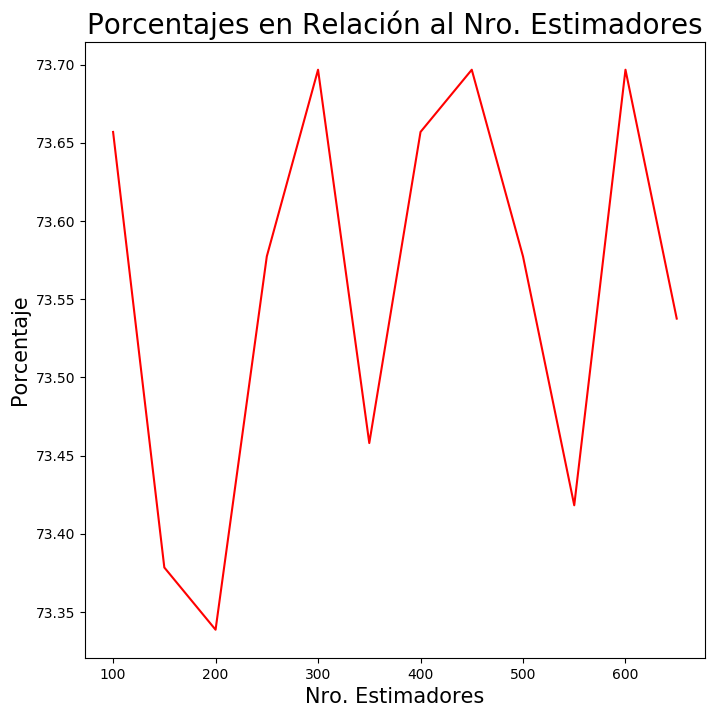

In [68]:
#Ploteamos para ver una mejor representacion
plt.subplots(figsize=(8,8))
plt.plot(rango_n,porcentajes_RF,color='red')
plt.title("Porcentajes en Relación al Nro. Estimadores",fontsize=20)
plt.xlabel("Nro. Estimadores",fontsize=15)
plt.ylabel("Porcentaje",fontsize=15)

In [69]:
RF = RandomForestClassifier(random_state=0, n_jobs=-1, n_estimators=350)

In [70]:
RF.fit(datos_train,target_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=350,
                       n_jobs=-1, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [71]:
prediccion_test_RF = RF.predict(test)

In [72]:
test_RF=test.copy()
test_RF['target']=prediccion_test_RF
test_RF.head()

,id,Tiene_arroba,Tiene_hashtag,Tiene_signo_pregunta,Tiene_signo_exclamacion,Tiene_link,"(0, 10]","(10, 20]","(20, 30]","(30, 40]",...,arianagrande,potus,foxnews,change,usatoday,emmerdale,justinbieber,djicemoon,stretcher,target
0,0,False,False,False,False,False,0,0,0,1,...,False,False,False,False,False,False,False,False,False,0
1,2,False,True,False,False,False,0,0,0,0,...,False,False,False,False,False,False,False,False,False,0
2,3,False,False,False,False,False,0,0,0,0,...,False,False,False,False,False,False,False,False,False,1
3,9,False,True,False,False,False,0,0,0,1,...,False,False,False,False,False,False,False,False,False,1
4,11,False,False,False,False,False,0,0,0,0,...,False,False,False,False,False,False,False,False,False,1


In [73]:
entregable_RF=test_RF[['id','target']]
entregable_RF.set_index('id',inplace=True)
entregable_RF.head()

,target
id,
0,0
2,0
3,1
9,1
11,1


In [74]:
entregable_RF.to_csv('Resultados/RF_4.csv')

### 3.3) Naive Bayes

In [75]:
gnb = GaussianNB()

In [76]:
gnb.fit(datos_train,target_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [77]:
prediccion_gnb = gnb.predict(datos_test)

print('Porcentaje: {0:.2f}%'.format(accuracy_score(target_test,prediccion_gnb)*100))

Porcentaje: 75.17%


In [78]:
prediccion_test_gnb = gnb.predict(test)

In [79]:
test_gnb=test.copy()
test_gnb['target']=prediccion_test_gnb
test_gnb.head()

,id,Tiene_arroba,Tiene_hashtag,Tiene_signo_pregunta,Tiene_signo_exclamacion,Tiene_link,"(0, 10]","(10, 20]","(20, 30]","(30, 40]",...,arianagrande,potus,foxnews,change,usatoday,emmerdale,justinbieber,djicemoon,stretcher,target
0,0,False,False,False,False,False,0,0,0,1,...,False,False,False,False,False,False,False,False,False,0
1,2,False,True,False,False,False,0,0,0,0,...,False,False,False,False,False,False,False,False,False,0
2,3,False,False,False,False,False,0,0,0,0,...,False,False,False,False,False,False,False,False,False,1
3,9,False,True,False,False,False,0,0,0,1,...,False,False,False,False,False,False,False,False,False,1
4,11,False,False,False,False,False,0,0,0,0,...,False,False,False,False,False,False,False,False,False,1


In [80]:
entregable_gnb=test_gnb[['id','target']]
entregable_gnb.set_index('id',inplace=True)
entregable_gnb.head()

,target
id,
0,0
2,0
3,1
9,1
11,1


In [81]:
entregable_gnb.to_csv('Resultados/NaiveBayes_4.csv')

### 3.4) Logistic Regression

In [82]:
LogReg = LogisticRegression()

In [83]:
LogReg.fit(datos_train,target_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [84]:
prediccion_LogReg = LogReg.predict(datos_test)

print('Porcentaje: {0:.2f}%'.format(accuracy_score(target_test,prediccion_LogReg)*100))

Porcentaje: 74.02%


In [85]:
prediccion_test_LogReg = LogReg.predict(test)

In [86]:
test_LogReg=test.copy()
test_LogReg['target']=prediccion_test_LogReg
test_LogReg.head()

,id,Tiene_arroba,Tiene_hashtag,Tiene_signo_pregunta,Tiene_signo_exclamacion,Tiene_link,"(0, 10]","(10, 20]","(20, 30]","(30, 40]",...,arianagrande,potus,foxnews,change,usatoday,emmerdale,justinbieber,djicemoon,stretcher,target
0,0,False,False,False,False,False,0,0,0,1,...,False,False,False,False,False,False,False,False,False,0
1,2,False,True,False,False,False,0,0,0,0,...,False,False,False,False,False,False,False,False,False,0
2,3,False,False,False,False,False,0,0,0,0,...,False,False,False,False,False,False,False,False,False,1
3,9,False,True,False,False,False,0,0,0,1,...,False,False,False,False,False,False,False,False,False,0
4,11,False,False,False,False,False,0,0,0,0,...,False,False,False,False,False,False,False,False,False,1


In [87]:
entregable_LogReg=test_LogReg[['id','target']]
entregable_LogReg.set_index('id',inplace=True)
entregable_LogReg.head()

,target
id,
0,0
2,0
3,1
9,0
11,1


In [88]:
entregable_LogReg.to_csv('Resultados/LogReg_4.csv')

### 3.5) SVM

In [89]:
SVM = svm.LinearSVC()

In [90]:
SVM.fit(datos_train,target_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [91]:
prediccion_SVM = SVM.predict(datos_test)

print('Porcentaje: {0:.2f}%'.format(accuracy_score(target_test,prediccion_SVM)*100))

Porcentaje: 59.57%


In [92]:
prediccion_test_SVM = SVM.predict(test)

In [93]:
test_SVM=test.copy()
test_SVM['target']=prediccion_test_SVM
test_SVM.head()

,id,Tiene_arroba,Tiene_hashtag,Tiene_signo_pregunta,Tiene_signo_exclamacion,Tiene_link,"(0, 10]","(10, 20]","(20, 30]","(30, 40]",...,arianagrande,potus,foxnews,change,usatoday,emmerdale,justinbieber,djicemoon,stretcher,target
0,0,False,False,False,False,False,0,0,0,1,...,False,False,False,False,False,False,False,False,False,1
1,2,False,True,False,False,False,0,0,0,0,...,False,False,False,False,False,False,False,False,False,1
2,3,False,False,False,False,False,0,0,0,0,...,False,False,False,False,False,False,False,False,False,1
3,9,False,True,False,False,False,0,0,0,1,...,False,False,False,False,False,False,False,False,False,1
4,11,False,False,False,False,False,0,0,0,0,...,False,False,False,False,False,False,False,False,False,1


In [94]:
entregable_SVM=test_SVM[['id','target']]
entregable_SVM.set_index('id',inplace=True)
entregable_SVM.head()

,target
id,
0,1
2,1
3,1
9,1
11,1


In [95]:
entregable_SVM.to_csv('Resultados/SVM_3.csv')

### 3.6) Redes Neuronales

In [96]:
Neural_Networks = MLPClassifier(solver='lbfgs',random_state=1)

In [97]:
Neural_Networks.fit(datos_train,target_train)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=1, shuffle=True, solver='lbfgs',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [98]:
prediccion_Neural_Networks = Neural_Networks.predict(datos_test)

print('Porcentaje: {0:.2f}%'.format(accuracy_score(target_test,prediccion_Neural_Networks)*100))

Porcentaje: 41.54%


In [99]:
prediccion_test_Neural_Networks = Neural_Networks.predict(test)

In [100]:
test_Neural_Networks=test.copy()
test_Neural_Networks['target']=prediccion_test_Neural_Networks
test_Neural_Networks.head()

,id,Tiene_arroba,Tiene_hashtag,Tiene_signo_pregunta,Tiene_signo_exclamacion,Tiene_link,"(0, 10]","(10, 20]","(20, 30]","(30, 40]",...,arianagrande,potus,foxnews,change,usatoday,emmerdale,justinbieber,djicemoon,stretcher,target
0,0,False,False,False,False,False,0,0,0,1,...,False,False,False,False,False,False,False,False,False,1
1,2,False,True,False,False,False,0,0,0,0,...,False,False,False,False,False,False,False,False,False,1
2,3,False,False,False,False,False,0,0,0,0,...,False,False,False,False,False,False,False,False,False,1
3,9,False,True,False,False,False,0,0,0,1,...,False,False,False,False,False,False,False,False,False,1
4,11,False,False,False,False,False,0,0,0,0,...,False,False,False,False,False,False,False,False,False,1


In [101]:
entregable_Neural_Networks=test_Neural_Networks[['id','target']]
entregable_Neural_Networks.set_index('id',inplace=True)
entregable_Neural_Networks.head()

,target
id,
0,1
2,1
3,1
9,1
11,1


In [102]:
entregable_Neural_Networks.to_csv('Resultados/Neural_Networks_1.csv')

### 3.7) KNN

In [103]:
#Busco el valor de K que nos de el mejor porcentaje
rango_k = range(1, 50)
porcentajes=[]

for k in rango_k:
    KNN = KNeighborsClassifier(n_neighbors=k,algorithm='kd_tree',metric='manhattan',n_jobs=-1)
    KNN.fit(datos_train,target_train)
    prediccion_KNN_validacion=KNN.predict(datos_test)
    porcentaje=(accuracy_score(target_test,prediccion_KNN_validacion)*100)

    print('K =',k,'- Porcentaje: {0:.2f}%'.format(porcentaje))
    porcentajes.append(porcentaje)

K = 1 - Porcentaje: 66.53%
K = 2 - Porcentaje: 68.68%
K = 3 - Porcentaje: 68.92%
K = 4 - Porcentaje: 69.52%
K = 5 - Porcentaje: 71.39%
K = 6 - Porcentaje: 71.51%
K = 7 - Porcentaje: 71.99%
K = 8 - Porcentaje: 71.95%
K = 9 - Porcentaje: 72.62%
K = 10 - Porcentaje: 72.11%
K = 11 - Porcentaje: 72.07%
K = 12 - Porcentaje: 71.87%
K = 13 - Porcentaje: 72.34%
K = 14 - Porcentaje: 72.54%
K = 15 - Porcentaje: 72.18%
K = 16 - Porcentaje: 71.71%
K = 17 - Porcentaje: 71.39%
K = 18 - Porcentaje: 71.31%
K = 19 - Porcentaje: 71.07%
K = 20 - Porcentaje: 70.95%
K = 21 - Porcentaje: 70.99%
K = 22 - Porcentaje: 70.99%
K = 23 - Porcentaje: 70.63%
K = 24 - Porcentaje: 71.35%
K = 25 - Porcentaje: 70.99%
K = 26 - Porcentaje: 71.11%
K = 27 - Porcentaje: 71.03%
K = 28 - Porcentaje: 71.63%
K = 29 - Porcentaje: 70.99%
K = 30 - Porcentaje: 71.39%
K = 31 - Porcentaje: 71.51%
K = 32 - Porcentaje: 71.39%
K = 33 - Porcentaje: 71.15%
K = 34 - Porcentaje: 71.31%
K = 35 - Porcentaje: 71.23%
K = 36 - Porcentaje: 71.19%
K

Text(0, 0.5, 'Porcentaje')

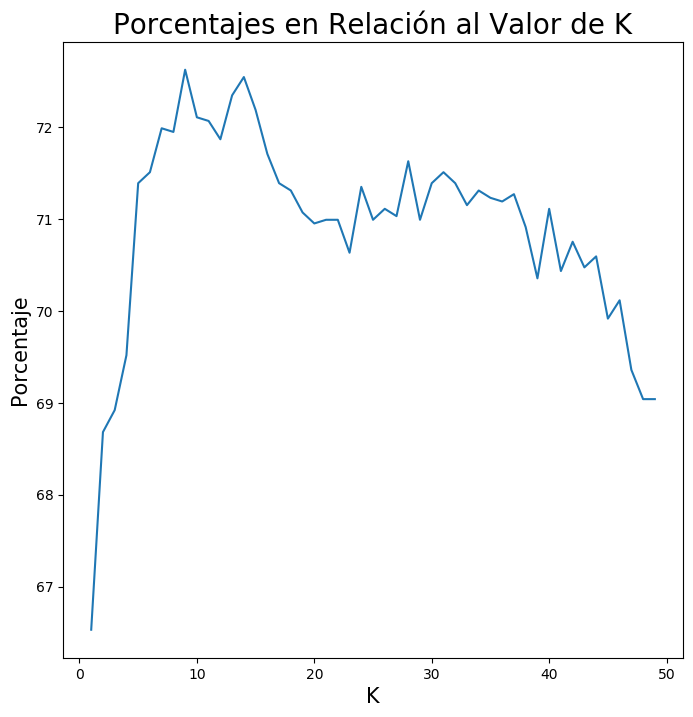

In [104]:
#Ploteamos para ver una mejor representacion
plt.subplots(figsize=(8,8))
plt.plot(rango_k,porcentajes)
plt.title("Porcentajes en Relación al Valor de K",fontsize=20)
plt.xlabel("K",fontsize=15)
plt.ylabel("Porcentaje",fontsize=15)

In [105]:
KNN = KNeighborsClassifier(n_neighbors=14,algorithm='kd_tree',metric='manhattan',n_jobs=-1)

In [106]:
KNN.fit(datos_train,target_train)

KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='manhattan',
                     metric_params=None, n_jobs=-1, n_neighbors=14, p=2,
                     weights='uniform')

In [107]:
prediccion_test_KNN = KNN.predict(test)

In [108]:
test_KNN=test.copy()
test_KNN['target']=prediccion_test_KNN
test_KNN.head()

,id,Tiene_arroba,Tiene_hashtag,Tiene_signo_pregunta,Tiene_signo_exclamacion,Tiene_link,"(0, 10]","(10, 20]","(20, 30]","(30, 40]",...,arianagrande,potus,foxnews,change,usatoday,emmerdale,justinbieber,djicemoon,stretcher,target
0,0,False,False,False,False,False,0,0,0,1,...,False,False,False,False,False,False,False,False,False,1
1,2,False,True,False,False,False,0,0,0,0,...,False,False,False,False,False,False,False,False,False,1
2,3,False,False,False,False,False,0,0,0,0,...,False,False,False,False,False,False,False,False,False,1
3,9,False,True,False,False,False,0,0,0,1,...,False,False,False,False,False,False,False,False,False,1
4,11,False,False,False,False,False,0,0,0,0,...,False,False,False,False,False,False,False,False,False,1


In [109]:
entregable_KNN=test_KNN[['id','target']]
entregable_KNN.set_index('id',inplace=True)
entregable_KNN.head()

,target
id,
0,1
2,1
3,1
9,1
11,1


In [110]:
entregable_KNN.to_csv('Resultados/KNN_1.csv')